##**Iris Data MultiClassification Using Keras** 

We are going to use the Iris flowers dataset. This is a multiclassification problem to be solved

#### Data Preperation

To prepare the data, we will simply use the **`OneHotEncoder`** to encode the integer features into a One-hot vector and we will use a `StandardScaler` to remove the mean and scale the features to unit variance. Finally we want to perform a train test split to compare our results later on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)

n_features = X.shape[1]
n_classes = Y.shape[1]

print("n_features" , n_features )
print("n_classes", n_classes)

n_features 4
n_classes 3


#### Data Visualization

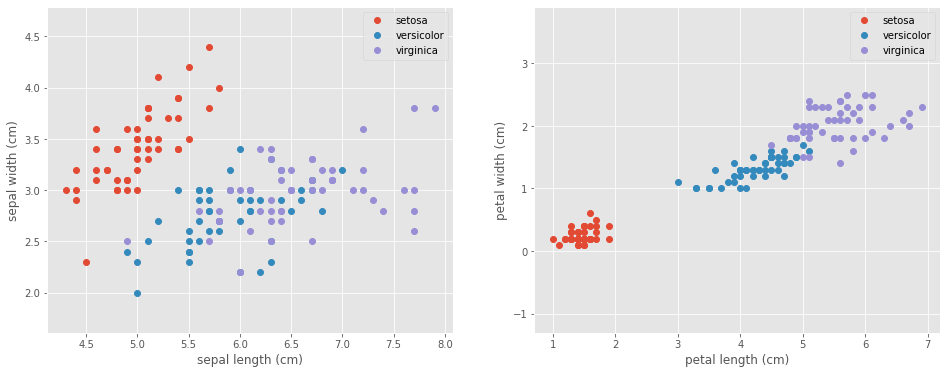

In [11]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

### Configure Neural Network Models

Now we configure the neural networks and we take a look at the summary of the models.

In [12]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras.layers import Dense

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
            
        model.add(Dense(output_dim, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 4)]

for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 3)        

### Train the Models

Let’s now run the training. We additionally use **`Tensorboard`** as a callback if we want to explore the model and the outputs in detail.

In [13]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.2778438329696655
Test accuracy: 0.9066666960716248
Model name: model_2
Test loss: 0.30274733901023865
Test accuracy: 0.8933333158493042
Model name: model_3
Test loss: 0.12377560883760452
Test accuracy: 0.9466666579246521


### Plot Accuracy and Loss from Training

Let’s have a look how our models perform. We can clearly see that adding more nodes makes the training perform better.

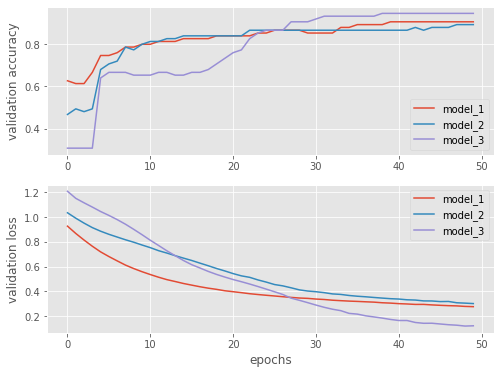

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accuracy = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accuracy, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

### ROC Curve

Plotting Receiver Operating Characteristic (ROC) curve, tells how well the models perform. 

**`The ROC plot compares the false positive rate with the true positive rate`**. We also compute for each model the Area under the curve (AUC), where auc = 1 is perfect classification and auc = 0.5 is random guessing (for a two class problem).

3/3 [==============================] - 0s 6ms/step


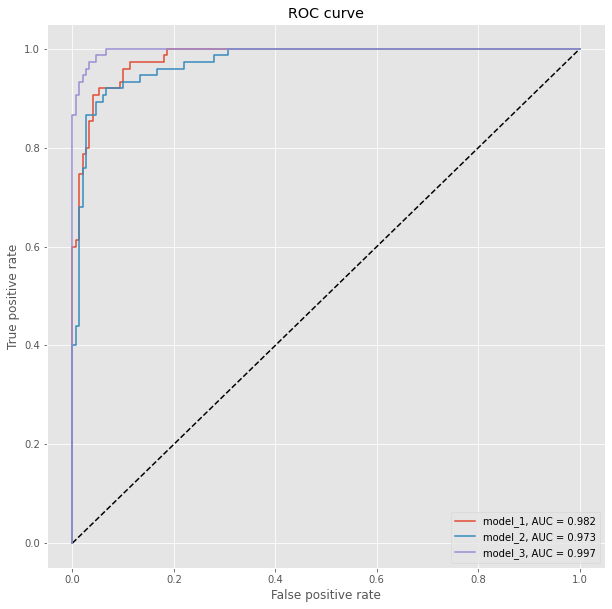

In [15]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

### Measure Performance with Cross Validation

Finally, we measure performance with 10-fold cross validation for the model_2 by using the KerasClassifier which is a handy Wrapper when using Keras together with scikit-learn. In this case we use the full data set.

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

create_model = create_custom_model(n_features, n_classes, 8, 3)

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
scores = cross_val_score(estimator, X_scaled, Y, cv=10)
print("Accuracy : {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))

Accuracy : 0.95 (+/- 0.07)
